In [390]:
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, FundamentalMatrixTransform, rotate
from skimage.color import rgb2gray
from skimage.measure import ransac

import pandas as pd
import numpy as np
import os

In [391]:
def get_parameters(dino_param_df):
    """
    Read the text file to get the parmeters of interest: K, R, T
    """

    param_dict = {}

    for i in range(len(dino_param_df)):
        row = dino_param_df.loc[i]
        K = np.array(row.loc[1:9].tolist()).reshape(3,3)
        R = np.array(row.loc[10:18].tolist()).reshape(3,3)
        T = np.array(row.loc[19:].tolist()).reshape(3,1)

        # param_dict[dino_param_df.loc[i][0]] = [K, R, T]
        param_dict[i] = [K, R, T]
    
    return param_dict


def get_translation_matrix(T):
    """
    T_mat = [ 0  -a3 a2]
            [ a3  0 -a1]
            [-a2 a1  0 ]
    """
    a1, a2, a3 = T

    T_mat = np.zeros((3,3))
    T_mat[0, 1] = -a3
    T_mat[0, 2] = a2
    T_mat[1, 0] = a3
    T_mat[1, 2] = -a1
    T_mat[2, 0] = -a2
    T_mat[2, 1] = a1

    return T_mat


def get_E_matrix(T, R):
    """
    E = [T]_x R
    """

    T_cross = get_translation_matrix(T)

    E_mat = T_cross @ R

    return E_mat

def get_F_matrix(K1, K2, E):
    """
    F = K^-T E K^-1
    """

    F_mat = np.linalg.inv(K1.T) @ E @ np.linalg.inv(K2)

    return F_mat

def get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2):
    """
    """

    P1 = K1 @ np.hstack([R1, T1])
    P2 = K2 @ np.hstack([R2, T2])

    # Calculate Pseudo-Inverse
    P1_pI = np.linalg.pinv(P1)
    
    # Camera center of the first camera
    C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
    
    # Camera center in homogenous coordinates
    C1 = np.hstack([C1, 1])
    
    # Epipole of C1 into second image
    E2 = P2 @ C1

    # Calculate F matrix
    E2_mat = get_translation_matrix(E2)
    F_mat = E2_mat @ P2 @ P1_pI

    return F_mat

In [392]:
# P1 = K1 @ np.hstack([R1, T1])
# P2 = K2 @ np.hstack([R2, T2])

# # Calculate Pseudo-Inverse
# P1_pI = np.linalg.pinv(P1)
    
# # Camera center of the first camera
# C1 = np.linalg.solve(P1[:, :-1], -P1[:, -1])
# P1[:, :-1] @ C1 + P1[:, -1]
    

In [393]:
# Read the original text file
path_to_dino_imgs = os.path.join(os.getcwd(), 'dinoSparseRing', 'dinoSR_par.txt')

dino_param_df = pd.read_table(path_to_dino_imgs, header=None, skiprows=[0], delim_whitespace=True)

In [394]:
# Reorganize the params
dino_params = get_parameters(dino_param_df=dino_param_df)

## Start with only two camera centers

In [419]:
C1_params = dino_params[1]
C2_params = dino_params[2]

In [420]:
# Calculate the Essential Matrix
    # Ci_params =  [K, R, T]

K1, R1, T1 = C1_params
K2, R2, T2 = C2_params

# R_rel = np.linalg.inv(R1) @ R2
# T_rel = T1-T2 #doing T2-T1 makes normal vector face down?


# E = get_E_matrix(T = T_rel, R = R_rel)
# # Calculate the Fundamental Matrix using K^-T E K^T
# F = get_F_matrix(K1, K2, E)

F = get_F_matrix_sourishghosh(K1, R1, T1, K2, R2, T2)

F

array([[ 3.61046213e-04,  5.18721343e-02,  8.26202536e+02],
       [ 4.88602923e-02, -5.27903923e-04, -6.56699958e+01],
       [-8.48974600e+02, -6.06721180e+01,  2.80184244e+04]])

In [421]:
def get_bound_box_intensities(im, point, bounding_box_size):
    u, v_dec = int(point[0]), point[1]
    v_ceil, v_floor = int(np.ceil(v_dec)), int(np.floor(v_dec))

    i = bounding_box_size//2

    im_cropped_list = []

    for v in [v_ceil, v_floor]:
        w_min, w_max = u - i, u + i
        h_min, h_max = v - i, v + i

        im_cropped_list.append(im[h_min:(h_max+1), w_min:(w_max+1), :])

    return im_cropped_list[0], v_ceil, im_cropped_list[1], v_floor

In [422]:
def loss_function(image_point, image_point_2, imL_cropped, imR_cropped):

    # Photoconsistency (?) + (Positional Consistency)
    loss = np.sum(np.abs(imL_cropped - imR_cropped)) + np.sum(np.abs(image_point - image_point_2))

    return loss

In [423]:
def get_right_epipolar_line(imR, x1, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x1_homo = np.append(x1, np.ones(len(x1))[:,None], axis = 1) 
    
    l2 = x1_homo @ F.T

    u = np.repeat(np.array([0, imR.shape[1]])[None,:], len(x1), axis=0) 

    v = predict_y(l2, u)

    return u, v, l2

In [424]:
def get_left_epipolar_line(imL, x2, F):
    """
    x1 are image points
    """

    def predict_y(l, x): 
        a = -np.divide(l[:,0], l[:,1]) 
        b = -np.divide(l[:,2], l[:,1]) 

        return np.multiply(a[:,None], x) + b[:,None] 
    
    x2_homo = np.append(x2, np.ones(len(x2))[:,None], axis = 1) 
    
    l1 = x2_homo @ F.T

    u = np.repeat(np.array([0, imL.shape[1]])[None,:], len(x1), axis=0) 

    v = predict_y(l1, u)

    return u, v, l1

In [425]:
def get_right_image_point(image_point, imL_cropped, x2_on_eline):
    final_image_point_2_list, final_loss_list = [], []

    for i in range(len(x2_on_eline)):
        # Testing if current point on epipolar line in image 2 works
        image_point_2 = x2_on_eline[i, :]
        
        # Return the (bounding_box_size x bounding_box_size x 3)
        imR_cropped_ceil, v_ceil, imR_cropped_floor, v_floor = get_bound_box_intensities(imR, image_point_2, bounding_box_size)

        # Custom loss functino
        image_point_2_list= [np.array([image_point_2[0], v_ceil]), np.array([image_point_2[0], v_floor])]
        
        # bb_int_L[0] = bb_int_L[1] since the image_point are all ints to begin with
    #     print(imL_cropped.shape, imR_cropped_ceil.shape)
        loss_list = [loss_function(image_point, image_point_2_list[0], imL_cropped, imR_cropped_ceil), \
                        loss_function(image_point, image_point_2_list[1], imL_cropped, imR_cropped_floor)]

        loss_arg = np.argmin(loss_list)
        
        image_point_2 = image_point_2_list[loss_arg]
        loss = loss_list[loss_arg]
        
        final_image_point_2_list.append(image_point_2)
        final_loss_list.append(loss)
    
    final_R_point = final_image_point_2_list[np.argmin(final_loss_list)]

    return final_R_point

In [426]:
def get_match_points_TEST(imL, x1, F, bounding_box_size):

    # Define some common variables:
        # after rotating img:(480 x 640 x 3)
    h,w,c = np.shape(imL)
    u = np.arange(w)

    u2_list, v2_list, l2_list = get_right_epipolar_line(imR, x1, F)

    x2_list = []
    for i in range(len(x1)):
        # (v, u) flipped coordinates
        image_point = np.array([x1[i, 0], x1[i, 1]])

        # l2 corresponding with the image_point
        l2 = l2_list[i,:]

        # Generate all points on epipolar line projected from first image plane
        a = -l2[0]/l2[1]
        b = -l2[2]/l2[1]

        # Produce all the points on the epipolar line
        u2 = np.arange(w)
        v2 = a*u+b
        
        # Extract all the points on the epipolar line that are within the image (and not restricted by the bounding_box_size)
        idx = np.where((v2 > bounding_box_size)&(v2 < h-bounding_box_size)& \
                (u2 > bounding_box_size)&(u2 < w-bounding_box_size))[0]
                
        u2 = u2[idx]
        v2 = v2[idx]

        
        # Stack the individual coordinates to make (n x 2) vector
        x2_on_eline = np.vstack([u2, v2]).T
        
        # For giving image_point and bounding_box_size return cropped array
        imL_cropped, v, _, _ = get_bound_box_intensities(imL, image_point, bounding_box_size)


        # Return final_R_point on the right image that is closest to image_point on the left image
        final_R_point = get_right_image_point(image_point, imL_cropped, x2_on_eline) 

        x2_list.append(final_R_point)

    x2 = np.array(x2_list)
    
    u1_list, v1_list, _ = get_left_epipolar_line(imL, x2, F)

    return x2, u1_list, v1_list, u2_list, v2_list

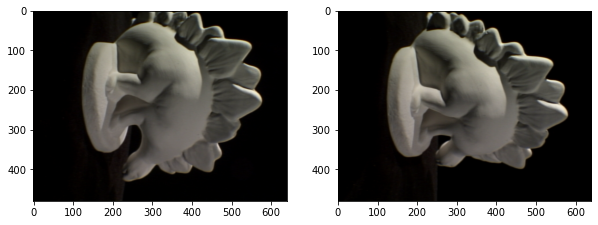

In [427]:
# Test using two images:
    # - WHEN THINGS WORKS, USE THIS CODE CHUNK TO RUN THROUGH ALL THE IMAGES

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0002.png")
imR = image.imread("dinoSparseRing/dinoSR0003.png")

# imL = rotate(imL, angle = 90)
# imR = rotate(imR, angle = 90)

imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

In [428]:
# SAMPLE RANDOM INDICES
h,w,c = np.shape(imL)
# Keep this an odd number to make things easier
bounding_box_size = 3
num_feature_points = 10

# mask = np.where(np.sum(imL, axis = 2) > 0.15, 1, 0)
mask_mike = np.where(np.sum(imL, axis = 2) > 0.4, 1, 0)
mask = mask_mike
maske1 = np.where(mask == 1)

points = np.array([maske1[1], maske1[0]]).T

idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points)
while not np.all((idx[1] > bounding_box_size)&(idx[1] < h-bounding_box_size)&(idx[0] > bounding_box_size)&(idx[0] < w-bounding_box_size)):
    idx = np.random.choice(np.arange(points.shape[0]), size = num_feature_points)



x1 = points[idx]

In [429]:
x2, u1_list, v1_list, u2_list, v2_list = get_match_points_TEST(imL, x1, F, bounding_box_size)

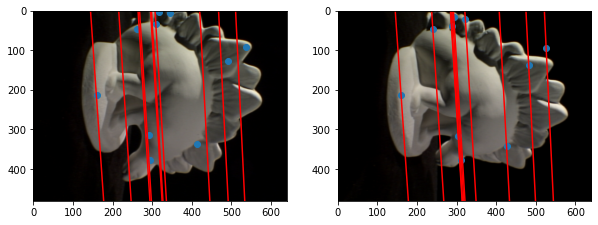

In [430]:
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 0], x1[:, 1])
for i in range(num_feature_points): 
    ax81.plot(u1_list[i], v1_list[i], '-r') 
    ax81.set_xlim((0, imR.shape[0])) 
    ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w)
plt.ylim(h, 0)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.scatter(x2[:, 0], x2[:, 1])
for i in range(num_feature_points): 
    ax82.plot(u2_list[i], v2_list[i], '-r') 
    ax82.set_xlim((0, imR.shape[0])) 
    ax82.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w)
plt.ylim(h, 0)
plt.show()

# Garbage from here and below

In [358]:
u2_list, v2_list = get_match_points_TEST(imL, x1, F, bounding_box_size)
u_list, v_list, l2_list = get_right_epipolar_line(imR, x1, F)




In [365]:
print(bounding_box_size)

idx = np.where((v2_list > bounding_box_size)&(v2_list < h-bounding_box_size)& \
                (u2_list > bounding_box_size)&(u2_list < w-bounding_box_size))[0]

3


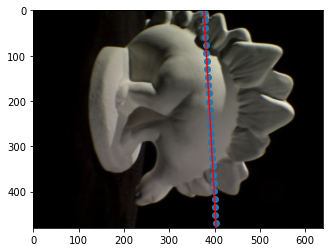

In [370]:
plt.imshow(imR)
plt.scatter(u2_list[idx], v2_list[idx])
plt.plot(u_list[0], v_list[0], '-r') 

plt.xlim(0, w)
plt.ylim(h, 0)
plt.show()

In [361]:
u2_list[0], v2_list[0], u2_list[-1], v2_list[-1]

(0, -6747.825652637129, 639, 4696.571300270253)

In [353]:
u_list, v_list

(array([[  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640],
        [  0, 640]]),
 array([[-7418.79471698,  4362.45689959],
        [-7591.87948518,  4271.64788941],
        [-7971.87052041,  4072.2854028 ],
        [-3462.58937541,  6438.08201001],
        [-3734.70391339,  6295.31698161],
        [-2439.08977539,  6975.06158687],
        [-4739.68769251,  5768.05173944],
        [-3122.538295  ,  6616.48997936],
        [-4290.98022796,  6003.46633505],
        [-3428.28579264,  6456.07940186]]))

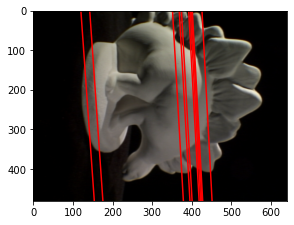

In [324]:
u_list, v_list, l2_list = get_right_epipolar_line(imR, x1, F)

plt.figure(0,figsize = (10, 4)) 
ax81 = plt.subplot(121) 
plt.imshow(imR) 
for i in range(num_feature_points): 
    ax81.plot(u_list[i], v_list[i], '-r') 
    ax81.set_xlim((0, imR.shape[0])) 
    ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w) 
plt.ylim(l, 0) 
plt.show()

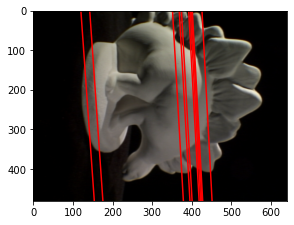

In [325]:
## Jack's little debugging space 
# # a. create an array of homogeneous points sampled in images 1 and 2 
ptsL_sample_homo = np.append(x1, np.ones(num_feature_points)[:,None], axis = 1) 
# b. create an array of the corresponding epipolar lines in images 1 and 2 
l2_sample = np.dot(ptsL_sample_homo, F.T) # Predict Y coordinates matrix given X matrix 
def predict_y(l, x): 
    a = -np.divide(l[:,0], l[:,1]) 
    b = -np.divide(l[:,2], l[:,1]) 
    return np.multiply(a[:,None], x) + b[:,None] 

ends = np.repeat(np.array([0, imR.shape[1]])[None,:], num_feature_points, axis=0) 
imR_y = predict_y(l2_sample, ends)

plt.figure(0,figsize = (10, 4)) 
ax81 = plt.subplot(121) 
plt.imshow(imR) 
for i in range(num_feature_points): 
    ax81.plot(ends[i], imR_y[i], '-r') 
    ax81.set_xlim((0, imR.shape[0])) 
    ax81.set_ylim((imR.shape[1], 0)) 

plt.xlim(0, w) 
plt.ylim(l, 0) 
plt.show()

NameError: name 'u' is not defined

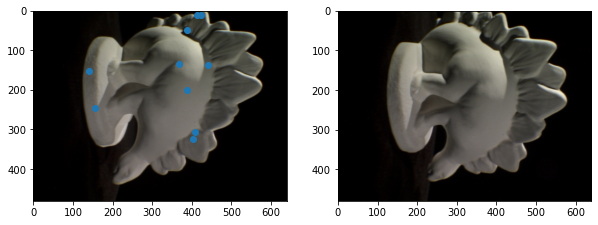

In [326]:
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 0], x1[:, 1])
# for i in range(len(e_L)):
#     plt.plot(e_L[i][1], e_L[i][0])
plt.xlim(0, w)
plt.ylim(l, 0)
ax82 = plt.subplot(122)
plt.imshow(imR)
# plt.scatter(R_points[:, 1], R_points[:, 0])
for i in range(len(u)):
    plt.plot(u[i,:], v[i,:])
plt.xlim(0, w)
plt.ylim(l, 0)
plt.show()

In [118]:
R_points, e_L, e_R = get_match_points(imL, imR, x1, F, bounding_box_size)

ValueError: attempt to get argmin of an empty sequence

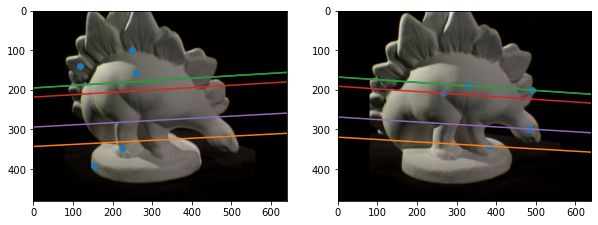

In [102]:
plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
plt.scatter(x1[:, 1], x1[:, 0])
for i in range(len(e_L)):
    plt.plot(e_L[i][1], e_L[i][0])
plt.xlim(0, w)
plt.ylim(l, 0)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.scatter(R_points[:, 1], R_points[:, 0])
for i in range(len(e_R)):
    plt.plot(e_R[i][1], e_R[i][0])
plt.xlim(0, w)
plt.ylim(l, 0)
plt.show()

In [1503]:
# # Map these indices to the second image using F
# x1_homo = np.hstack([x1, np.ones(shape=(len(x1), 1), dtype=int)])
# x1_homo


# # each column represents the coefficients of line equation of l1 = Fx2
# Fx = np.dot(F, x1_homo.T)

# final_R_points_list = []
# epipolar_line_L_list = []
# epipolar_line_R_list = []
# u = np.arange(l-1)
# v = np.arange(w-1)
# for i in range(len(x1)):
    
#     original_L_point = np.array([x1[i, 0], x1[i, 1]])
#     l1 = Fx[:, i]
#     u_pt_on_l1_not_int = -(1/l1[0])*(v*l1[1]+l1[2])
    
#     u_pt_on_l1 = np.around(u_pt_on_l1_not_int.astype('int'))
    

#     # Indices of the second image
#     x2_on_eline = np.vstack([u_pt_on_l1, v]).T
#     # # Location out NOT out of bounds
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 0] < l - bounding_box_size, :]
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 0] > bounding_box_size, :]

#     x2_on_eline = x2_on_eline[x2_on_eline[:, 1] < w - bounding_box_size, :]
#     x2_on_eline = x2_on_eline[x2_on_eline[:, 1] > bounding_box_size, :]
    
#     if len(x2_on_eline) != 0:
#         epipolar_line_R_list.append([u_pt_on_l1_not_int, v])
#         bb_int_L = get_bound_box_intensities(imL, original_L_point, bounding_box_size)
#         loss_list = []
#         for i in range(len(x2_on_eline)):
            
#             point = x2_on_eline[i, :]
#             bb_int_R = get_bound_box_intensities(imR, point, bounding_box_size)

#             if len(bb_int_R) != 0:

#                 loss = np.sum(np.square(bb_int_L - bb_int_R)) + (1/2)*np.sum(np.abs(original_L_point - point))
#                 loss_list.append(loss)

#         final_R_point = x2_on_eline[np.argmin(loss_list), :]
#         xF = np.dot((np.hstack([final_R_point, 1])).T, F)
#         l2 = xF
#         v_pt_on_l2_not_int = -(1/l2[1])*(u*l2[0]+l2[2])
#         epipolar_line_L_list.append([u, v_pt_on_l2_not_int])

#         final_R_points_list.append(final_R_point)

# final_R_points = np.array(final_R_points_list)



In [1504]:
mask[(x1[:, 0], x1[:, 1])]

# x1[0, 0], x1[0, 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [1505]:
# proper_points_list = []

# i = 0

# original_L_point = np.array([x1[i, 0], x1[i, 1]])
# l1 = Fx[:, i]
# u_pt_on_l1 = -(1/l1[0])*(v*l1[1]+l1[2])
# u_pt_on_l1 = np.around(u_pt_on_l1.astype('int'))


# # Indices of the second image
# x2_on_eline = np.vstack([u_pt_on_l1, v]).T
# # Location out NOT out of bounds
# x2_on_eline = x2_on_eline[x2_on_eline[:, 0] < l, :]

# # Intensity values of the 3 channels
# vec = imL[x2_on_eline[:,0],x2_on_eline[:,1], :]

# # Location of not BLACK areas
# bool_not_all_zeros = ~np.all(vec == 0, axis = 1)

# # Indices where not black and not out of bounds
# x2_on_eline = x2_on_eline[bool_not_all_zeros]

# bb_int_L, original_L_point = get_bound_box_intensities(imL, original_L_point, bounding_box_size)
# loss_list = []
# for i in range(len(x2_on_eline)):
#     point = x2_on_eline[i, :]
#     bb_int_R, point_R = get_bound_box_intensities(imR, point, bounding_box_size)

#     loss = np.sum(np.square(bb_int_L - bb_int_R))
#     loss_list.append(loss)

# proper_points_list.append(x2_on_eline[np.argmin(loss_list), :])









In [1506]:
mse

2.71674

In [1507]:
bool_not_all_zeros

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

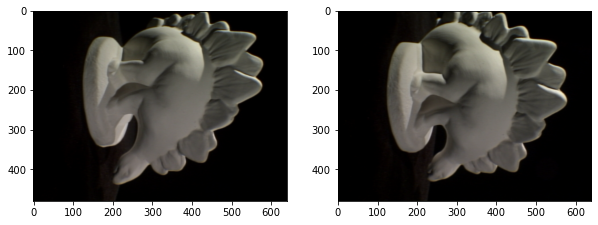

In [1508]:
# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("dinoSparseRing/dinoSR0001.png")
imR = image.imread("dinoSparseRing/dinoSR0002.png")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

the number of features in images 1 and 2 are    39 and    36


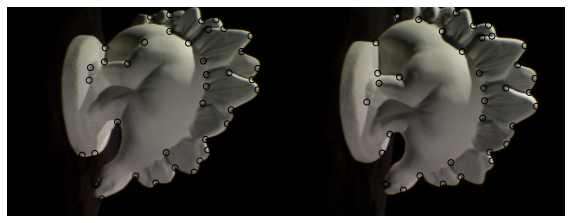

In [1509]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

the number of matches is 24


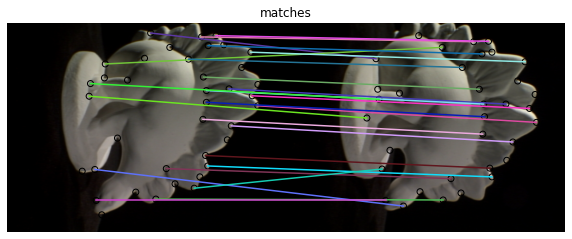

In [1510]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

the number of inliers is  9


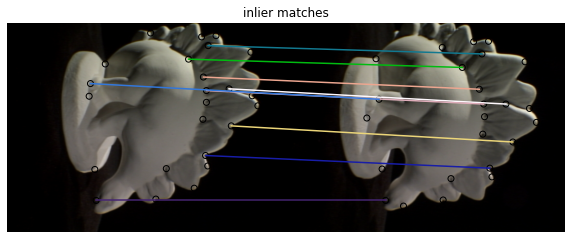

In [1511]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()